In [2]:
pip install -U langchain-tavily

In [3]:
pip install -U langgraph langsmith

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.8/384.8 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.4.24
    Uninstalling langsmith-0.4.24:
      Successfully uninstalled langsmith-0.4.24


In [ ]:
import os

os.environ["TAVILY_API_KEY"] = "***"

In [5]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'state' in LangGraph?")

In [6]:
pip install -U "langchain[google-genai]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.8 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [ ]:
import os
from langchain.chat_models import init_chat_model

os.environ["GOOGLE_API_KEY"] = "***"

llm = init_chat_model("google_genai:gemini-2.0-flash")

In [8]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [9]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [10]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

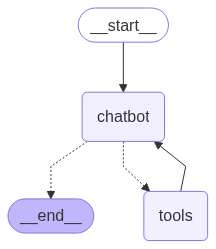

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: tell me a major event that happened today
Assistant: 
Assistant: {"query": "major event today", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/Portal:Current_events", "title": "Portal:Current events", "content": "American political activist Charlie Kirk (pictured) is shot and killed at an event in Utah, United States. Israel attacks the Hamas leadership in Doha,", "score": 0.28584066, "raw_content": null}, {"url": "https://www.usatoday.com/news/world/", "title": "Current Events & World News", "content": "Trump talks sanctions on Russia after largest air attack on Ukraine \u00b7 Nepal PM quits after 19 killed in protests triggered by social media ban \u00b7 Thai ex-PM", "score": 0.2597322, "raw_content": null}], "response_time": 1.13, "request_id": "1f6309eb-c286-4420-9d7f-46ef2a32aaba"}
Assistant: Based on the search results, here are a couple of major events that may have happened today:

*   American political activ